### 1. <a id='importation'>Détail des données fournies</a>

In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import warnings
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder


# Ignorer les avertissements
warnings.filterwarnings('ignore')
path = "../data/"

DELIMITER = "--------------------------------"

---

### 2. <a id='chargement'>Chargement et initialisation des données</a>

In [98]:
#On vient charger les différents dataset
employee_df = pd.read_csv(path + "employee_survey_data.csv")
general_df = pd.read_csv(path + "general_data.csv")
manager_df = pd.read_csv(path + "manager_survey_data.csv")
in_time_df = pd.read_csv(path + "in_time.csv")
out_time_df = pd.read_csv(path + "out_time.csv")

dataframes = [
    ("employee_df", employee_df),
    ("general_df", general_df),
    ("manager_df", manager_df),
    ("in_time_df", in_time_df),
    ("out_time_df", out_time_df)
]

for name, df in dataframes:
    print(f"Nom du DataFrame : {name}")
    print(f"Description : {df.describe()}")
    print(f" Valeurs nulles : {df.isnull().sum()}")


# result employee_survey = pd.read_csv('../data/cleaned_employee_survey.csv')
#general_data = pd.read_csv('../data/cleaned_general_data.csv')
#manager_survey = pd.read_csv('../data/cleaned_manager_survey.csv')
#total_hours_per_employee = pd.read_csv('../data/total_hours_per_employee.csv')

Nom du DataFrame : employee_df
Description :         EmployeeID  EnvironmentSatisfaction  JobSatisfaction  WorkLifeBalance
count  4410.000000              4385.000000      4390.000000      4372.000000
mean   2205.500000                 2.723603         2.728246         2.761436
std    1273.201673                 1.092756         1.101253         0.706245
min       1.000000                 1.000000         1.000000         1.000000
25%    1103.250000                 2.000000         2.000000         2.000000
50%    2205.500000                 3.000000         3.000000         3.000000
75%    3307.750000                 4.000000         4.000000         3.000000
max    4410.000000                 4.000000         4.000000         4.000000
 Valeurs nulles : EmployeeID                  0
EnvironmentSatisfaction    25
JobSatisfaction            20
WorkLifeBalance            38
dtype: int64
Nom du DataFrame : general_df
Description :                Age  DistanceFromHome    Education  Employe

---

Résumé des différentes données présentes dans les dataset:
(ce qu'on a fait dans chaque notebook)


---


### 3. <a id='merge'>Pré-traitements spécifique</a>

Notre objectif est de venir merger ces différents dataset afin de travailler avec un seul DataFrame.
En observant les différentes caractéristiques des dataset, on s'est aperçu qu'on peut dès à présent fusionner tous les dataset sauf "in_time" et "out_time" car les informations présentes sont très différentes des autres dataset, sur la forme ou le fond.
On va donc venir synthétiser ces données afin de récupérer l'heure totale de travail pour chaque employé.


In [99]:
in_time_df = in_time_df.rename(columns={"Unnamed: 0": "EmployeeID"})
out_time_df = out_time_df.rename(columns={"Unnamed: 0": "EmployeeID"})

### Vérifications concernant les 2 dataset :

# Valeurs des EmployeeID
if not in_time_df['EmployeeID'].equals(out_time_df['EmployeeID']):
    print("Les EmployeeID ne correspondent pas entre les dataset : in_time_df et out_time_df")

# Correspondance des valeurs NA
in_time_na = in_time_df.isna()
out_time_na = out_time_df.isna()
if not in_time_na.equals(out_time_na):
    print("Les valeurs NA dans in_time_df et out_time_df ne correspondent pas")

### On est maintenant sûr que les dataset sont conformes et peuvent donc être fusionnés, on va venir convertir les objets en date afin de récuperer les heures totales.

for col in in_time_df.columns[1:]:
    in_time_df[col] = pd.to_datetime(in_time_df[col], errors='coerce')
    out_time_df[col] = pd.to_datetime(out_time_df[col], errors='coerce')

time_difference = out_time_df.iloc[:, 1:] - in_time_df.iloc[:, 1:]

time_difference_in_hours = time_difference.apply(lambda row: row.dt.total_seconds() / 3600, axis=1)
total_hours_per_employee = time_difference_in_hours.sum(axis=1, skipna=True).round(2)

# Ajouter une colonne pour la durée totale
out_time_df["Total_Hours"] = total_hours_per_employee
total_hours_df = out_time_df[["EmployeeID", "Total_Hours"]]

### 3. <a id='merge'>Merge et sauvegarde des datasets</a>

In [100]:
company_df = general_df.merge(employee_df, on='EmployeeID').merge(manager_df, on='EmployeeID').merge(total_hours_df, on='EmployeeID')
company_df

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,...,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating,Total_Hours
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,1,Female,...,6,1,0,0,3.0,4.0,2.0,3,3,1710.69
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,2,Female,...,3,5,1,4,3.0,2.0,4.0,2,4,1821.68
2,32,No,Travel_Frequently,Research & Development,17,4,Other,1,3,Male,...,2,5,0,3,2.0,2.0,1.0,3,3,1697.20
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,1,4,Male,...,5,8,7,5,4.0,4.0,3.0,2,3,1690.51
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,1,5,Male,...,2,6,0,4,4.0,1.0,3.0,3,3,1961.51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4405,42,No,Travel_Rarely,Research & Development,5,4,Medical,1,4406,Female,...,5,3,0,2,4.0,1.0,3.0,3,3,2070.91
4406,29,No,Travel_Rarely,Research & Development,2,4,Medical,1,4407,Male,...,2,3,0,2,4.0,4.0,3.0,2,3,1468.40
4407,25,No,Travel_Rarely,Research & Development,25,2,Life Sciences,1,4408,Male,...,4,4,1,2,1.0,3.0,3.0,3,4,1780.23
4408,42,No,Travel_Rarely,Sales,18,2,Medical,1,4409,Male,...,2,9,7,8,4.0,1.0,3.0,2,3,2287.72


---

### 4. <a id='apercu'>Aperçu général</a>

In [101]:
print(f"Nombre de lignes : {company_df.shape[0]}")
print(f"Nombre de colonnes : {company_df.shape[1]}")

Nombre de lignes : 4410
Nombre de colonnes : 30


In [102]:
print("Informations de base :")
company_df.info()

Informations de base :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      4410 non-null   int64  
 1   Attrition                4410 non-null   object 
 2   BusinessTravel           4410 non-null   object 
 3   Department               4410 non-null   object 
 4   DistanceFromHome         4410 non-null   int64  
 5   Education                4410 non-null   int64  
 6   EducationField           4410 non-null   object 
 7   EmployeeCount            4410 non-null   int64  
 8   EmployeeID               4410 non-null   int64  
 9   Gender                   4410 non-null   object 
 10  JobLevel                 4410 non-null   int64  
 11  JobRole                  4410 non-null   object 
 12  MaritalStatus            4410 non-null   object 
 13  MonthlyIncome            4410 non-null   int64  
 14  N

In [103]:
print(f"Sommaire des statistiques : \n{company_df.describe()}")

Sommaire des statistiques : 
               Age  DistanceFromHome    Education  EmployeeCount   EmployeeID  \
count  4410.000000       4410.000000  4410.000000         4410.0  4410.000000   
mean     36.923810          9.192517     2.912925            1.0  2205.500000   
std       9.133301          8.105026     1.023933            0.0  1273.201673   
min      18.000000          1.000000     1.000000            1.0     1.000000   
25%      30.000000          2.000000     2.000000            1.0  1103.250000   
50%      36.000000          7.000000     3.000000            1.0  2205.500000   
75%      43.000000         14.000000     4.000000            1.0  3307.750000   
max      60.000000         29.000000     5.000000            1.0  4410.000000   

          JobLevel  MonthlyIncome  NumCompaniesWorked  PercentSalaryHike  \
count  4410.000000    4410.000000         4391.000000        4410.000000   
mean      2.063946   65029.312925            2.694830          15.209524   
std       1.1

In [104]:
print("Nombre de valeurs uniques par colonne :")
for column in company_df.columns:
    print(f"- {column} : {company_df[column].nunique()} valeurs uniques")

Nombre de valeurs uniques par colonne :
- Age : 43 valeurs uniques
- Attrition : 2 valeurs uniques
- BusinessTravel : 3 valeurs uniques
- Department : 3 valeurs uniques
- DistanceFromHome : 29 valeurs uniques
- Education : 5 valeurs uniques
- EducationField : 6 valeurs uniques
- EmployeeCount : 1 valeurs uniques
- EmployeeID : 4410 valeurs uniques
- Gender : 2 valeurs uniques
- JobLevel : 5 valeurs uniques
- JobRole : 9 valeurs uniques
- MaritalStatus : 3 valeurs uniques
- MonthlyIncome : 1349 valeurs uniques
- NumCompaniesWorked : 10 valeurs uniques
- Over18 : 1 valeurs uniques
- PercentSalaryHike : 15 valeurs uniques
- StandardHours : 1 valeurs uniques
- StockOptionLevel : 4 valeurs uniques
- TotalWorkingYears : 40 valeurs uniques
- TrainingTimesLastYear : 7 valeurs uniques
- YearsAtCompany : 37 valeurs uniques
- YearsSinceLastPromotion : 16 valeurs uniques
- YearsWithCurrManager : 18 valeurs uniques
- EnvironmentSatisfaction : 4 valeurs uniques
- JobSatisfaction : 4 valeurs uniques


In [105]:
display(company_df.head())

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,...,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating,Total_Hours
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,1,Female,...,6,1,0,0,3.0,4.0,2.0,3,3,1710.69
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,2,Female,...,3,5,1,4,3.0,2.0,4.0,2,4,1821.68
2,32,No,Travel_Frequently,Research & Development,17,4,Other,1,3,Male,...,2,5,0,3,2.0,2.0,1.0,3,3,1697.20
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,1,4,Male,...,5,8,7,5,4.0,4.0,3.0,2,3,1690.51
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,1,5,Male,...,2,6,0,4,4.0,1.0,3.0,3,3,1961.51


---

### 5. <a id='missing-check'>Gestion des valeurs manquantes</a>

In [106]:
if (company_df.isnull().sum() > 0).any():
    missing_values = company_df.isnull().sum()[company_df.isnull().sum() > 0]
    missing_percentage = (missing_values / len(company_df) * 100).round(2)
    print("Valeurs manquantes par colonne :")
    for col in missing_values.index:
        print(f"{col} : {missing_values[col]} valeurs ({missing_percentage[col]}%)")
else:
    print("Il n'y a pas de valeurs manquantes dans le dataset")

Valeurs manquantes par colonne :
NumCompaniesWorked : 19 valeurs (0.43%)
TotalWorkingYears : 9 valeurs (0.2%)
EnvironmentSatisfaction : 25 valeurs (0.57%)
JobSatisfaction : 20 valeurs (0.45%)
WorkLifeBalance : 38 valeurs (0.86%)


---

### 6. <a id='doublons'>Gestion des valeurs dupliquées</a>

In [107]:
if company_df.duplicated().sum() > 0:
    print(f"Nombre de valeurs dupliquées : {company_df.duplicated().sum()}")
    merged_dataset = company_df.drop_duplicates()
    print(f"Nombre de lignes après suppression des doublons : {merged_dataset.shape[0]}")
else:
    print("Il n'y a pas de valeurs dupliquées dans le dataset")

Il n'y a pas de valeurs dupliquées dans le dataset


---

### 7. <a id='types'>Vérification des types de données</a>

In [108]:
numerical_columns = company_df.select_dtypes(include=['int64', 'float64']).columns

for column in numerical_columns:
    invalid_values = company_df[column].apply(lambda x: isinstance(x, (str)))
    if invalid_values.any():
        print(f"La colonne {column} contient des valeurs non numériques :")
        print(company_df[invalid_values][column])
        print(DELIMITER)

if not invalid_values.any():
    print("Aucune valeur non numérique a été trouvée dans les colonnes numériques")

Aucune valeur non numérique a été trouvée dans les colonnes numériques


In [109]:
categorical_columns = company_df.select_dtypes(include=['object']).columns

for column in categorical_columns:
    print(f"Vérification des valeurs uniques dans la colonne {column}")
    print(company_df[column].unique())
    print(DELIMITER)

Vérification des valeurs uniques dans la colonne Attrition
['No' 'Yes']
--------------------------------
Vérification des valeurs uniques dans la colonne BusinessTravel
['Travel_Rarely' 'Travel_Frequently' 'Non-Travel']
--------------------------------
Vérification des valeurs uniques dans la colonne Department
['Sales' 'Research & Development' 'Human Resources']
--------------------------------
Vérification des valeurs uniques dans la colonne EducationField
['Life Sciences' 'Other' 'Medical' 'Marketing' 'Technical Degree'
 'Human Resources']
--------------------------------
Vérification des valeurs uniques dans la colonne Gender
['Female' 'Male']
--------------------------------
Vérification des valeurs uniques dans la colonne JobRole
['Healthcare Representative' 'Research Scientist' 'Sales Executive'
 'Human Resources' 'Research Director' 'Laboratory Technician'
 'Manufacturing Director' 'Sales Representative' 'Manager']
--------------------------------
Vérification des valeurs uniqu

---

### 8. <a id='pipeline'>Pipeline de traitement des données</a>

In [114]:
# Automatically identify numerical and categorical columns
num_features = company_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_features = company_df.select_dtypes(include=['object', 'category']).columns.tolist()


# Pipeline pour les variables numériques
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),  # Remplissage des valeurs manquantes
    ('scaler', StandardScaler())  # Normalisation des données
])

# Pipeline pour les variables catégorielles
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Remplissage des valeurs manquantes
    ('encoder', OneHotEncoder(handle_unknown='ignore'))  # Encodage OneHot
])

# Pipeline global combinant les transformations
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features)
])

# Modèle d'apprentissage (exemple : Régression Logistique)
model = Pipeline([
    ('preprocessing', preprocessor),
])

# Appliquer la transformation sur les données d'origine
transformed_data = preprocessor.fit_transform(company_df)

# Récupérer les noms des nouvelles colonnes après transformation
cat_encoder = preprocessor.named_transformers_['cat'].named_steps['encoder']
cat_one_hot_columns = cat_encoder.get_feature_names_out(cat_features).tolist()

# Créer le DataFrame transformé
processed_df = pd.DataFrame(transformed_data, columns=num_features + cat_one_hot_columns)

# Afficher les premières lignes du DataFrame transformé
processed_df.head()

,Age,DistanceFromHome,Education,EmployeeCount,EmployeeID,JobLevel,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StandardHours,...,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,Over18_Y
0,1.541369,-0.393938,-0.891688,0.0,-1.731658,-0.961486,1.405136,-0.678464,-1.150554,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,-0.648668,0.099639,-1.868426,0.0,-1.730873,-0.961486,-0.491661,-1.079486,2.129306,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
2,-0.539166,0.963398,1.061787,0.0,-1.730087,1.749610,2.725053,-0.678464,-0.057267,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
3,0.117845,-0.887515,2.038524,0.0,-1.729302,0.845911,0.386301,0.123580,-1.150554,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,-0.539166,0.099639,-1.868426,0.0,-1.728516,-0.961486,-0.884109,0.524602,-0.877232,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0


# <font color="red"><center>**WIP**</center></font>

In [59]:

# Étape 2: Calcul de la matrice de corrélation pour toutes les variables numériques
num_columns = company_df.select_dtypes(include=['int64', 'float64']).columns
corr_matrix = company_df[num_columns].corr()
# Étape 3: Filtrer les paires avec un coefficient de corrélation supérieur au seuil
# Définir le seuil (par exemple, 0.3)
seuil = 0.3

# Créer une liste pour stocker les paires de variables corrélées
correlated_pairs = []

# Parcourir la matrice de corrélation
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        var1 = corr_matrix.columns[i]
        var2 = corr_matrix.columns[j]
        corr_value = corr_matrix.iloc[i, j]

        # Ajouter la paire à la liste si la corrélation est supérieure au seuil
        if abs(corr_value) > seuil:
            correlated_pairs.append({'Variable 1': var1, 'Variable 2': var2, 'Correlation': corr_value})

# Convertir en DataFrame pour visualiser les résultats
correlated_pairs_df = pd.DataFrame(correlated_pairs)
positive_corr_df = correlated_pairs_df[correlated_pairs_df['Correlation'] > 0].sort_values(by='Correlation', ascending=False)
negative_corr_df = correlated_pairs_df[correlated_pairs_df['Correlation'] < 0].sort_values(by='Correlation')
# Afficher les paires avec une corrélation élevée
print("Paires de variables avec une corrélation significative :")
correlated_pairs_df


Paires de variables avec une corrélation significative :


,Variable 1,Variable 2,Correlation
0,Age,TotalWorkingYears,0.680661
1,Age,YearsAtCompany,0.311309
2,PercentSalaryHike,PerformanceRating,0.773550
3,TotalWorkingYears,YearsAtCompany,0.627703
4,TotalWorkingYears,YearsSinceLastPromotion,0.404444
5,TotalWorkingYears,YearsWithCurrManager,0.458800
6,YearsAtCompany,YearsSinceLastPromotion,0.618409
7,YearsAtCompany,YearsWithCurrManager,0.769212
8,YearsSinceLastPromotion,YearsWithCurrManager,0.510224


In [60]:
# Display both dataframes
positive_corr_df

,Variable 1,Variable 2,Correlation
2,PercentSalaryHike,PerformanceRating,0.773550
7,YearsAtCompany,YearsWithCurrManager,0.769212
0,Age,TotalWorkingYears,0.680661
3,TotalWorkingYears,YearsAtCompany,0.627703
6,YearsAtCompany,YearsSinceLastPromotion,0.618409
8,YearsSinceLastPromotion,YearsWithCurrManager,0.510224
5,TotalWorkingYears,YearsWithCurrManager,0.458800
4,TotalWorkingYears,YearsSinceLastPromotion,0.404444
1,Age,YearsAtCompany,0.311309


In [61]:
negative_corr_df

,Variable 1,Variable 2,Correlation


In [62]:
def bivariate_num_num_analysis(df, var1, var2):
    """
    Effectue une analyse bivariée complète entre deux variables numériques,
    incluant la covariance, les corrélations, les tests de corrélation et une régression linéaire.

    Arguments :
    - df : DataFrame contenant les données.
    - var1 : Nom de la première variable numérique.
    - var2 : Nom de la deuxième variable numérique.

    Retourne :
    - Un dictionnaire avec les résultats des statistiques descriptives, des tests de corrélation et de la régression linéaire.
    """

    # Calcul de la covariance entre var1 et var2
    covariance = np.cov(df[var1], df[var2])[0, 1]

    # Calcul de la corrélation de Pearson
    pearson_corr, pearson_p_value = stats.pearsonr(df[var1], df[var2])

    # Calcul de la corrélation de Spearman
    spearman_corr, spearman_p_value = stats.spearmanr(df[var1], df[var2])

    # Modèle de régression linéaire
    X = df[[var1]]
    y = df[var2]
    model = LinearRegression().fit(X, y)
    intercept = model.intercept_
    slope = model.coef_[0]
    r_squared = model.score(X, y)

    # Affichage structuré des résultats
    print(f"\n--- Analyse Bivariée entre {var1} et {var2} ---\n")
    print("**Statistiques de Corrélation et Covariance**")
    print(f"- Covariance : {covariance:.4f}")
    print(f"- Corrélation de Pearson : {pearson_corr:.4f} (p-valeur : {pearson_p_value:.4e})")
    print(f"- Corrélation de Spearman : {spearman_corr:.4f} (p-valeur : {spearman_p_value:.4e})\n")

    print("**Régression Linéaire**")
    print(f"- Pente : {slope:.4f}")
    print(f"- Intercept : {intercept:.4f}")
    print(f"- Coefficient de détermination (R²) : {r_squared:.4f}")



In [63]:
def correlation_heatmap(df):
    """
    Tracer une heatmap pour visualiser la matrice de corrélation entre toutes les variables quantitatives.

    Arguments:
    - df: DataFrame contenant les données
    """
    corr_matrix = df.corr()
    plt.figure(figsize=(12, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title("Matrice de Corrélation entre les Variables Quantitatives")
    plt.show()

def scatter_plot(df, var1, var2):
    """
    Tracer un scatter plot entre deux variables quantitatives.

    Arguments:
    - df: DataFrame contenant les données
    - var1: Nom de la première variable
    - var2: Nom de la deuxième variable
    """
    sns.scatterplot(data=df, x=var1, y=var2,color="blue", alpha=0.5, s=10)# Nuage de points
    sns.kdeplot(data=df, x=var1, y=var2, cmap="Reds", fill=False, thresh=0.05)# Contours de densité
    plt.title(f"Scatter Plot avec Contours de Densité Bivariée entre {var1} et {var2}")
    plt.xlabel(var1)
    plt.ylabel(var2)
    plt.show()


def plot_bivariate_density(df, var1, var2):
    """
    Trace une carte de densité bivariée (KDE) entre deux variables numériques.

    Cette fonction permet de visualiser les zones de concentration des observations entre deux variables numériques,
    offrant un aperçu des relations possibles entre elles.

    Arguments :
    - df : DataFrame contenant les données.
    - var1 : Nom de la première variable numérique (axe des x).
    - var2 : Nom de la deuxième variable numérique (axe des y).
    """
    plt.figure(figsize=(8, 6))
    sns.kdeplot(data=df, x=var1, y=var2, cmap="Blues", fill=True, thresh=0.05)
    plt.title(f"Densité Bivariée entre {var1} et {var2}")
    plt.xlabel(var1)
    plt.ylabel(var2)
    plt.show()



def linear_regression_plot(df, var1, var2):
    """
    Tracer une régression linéaire entre deux variables quantitatives.

    Arguments:
    - df: DataFrame contenant les données
    - var1: Nom de la première variable
    - var2: Nom de la deuxième variable
    """
    plt.figure(figsize=(10, 6))
    sns.regplot(x=var1, y=var2, data=df, scatter_kws={'s':10}, line_kws={'color': 'red'})
    plt.title(f"Régression Linéaire entre {var1} et {var2}")
    plt.xlabel(var1)
    plt.ylabel(var2)
    plt.show()


def joint_plot(df, var1, var2):
    """
    Créer un jointplot pour visualiser la relation entre deux variables numériques,
    avec les distributions individuelles de chaque variable.

    Arguments:
    - df: DataFrame contenant les données
    - var1: Nom de la première variable numérique
    - var2: Nom de la deuxième variable numérique
    """
    # Création du joint plot
    sns.jointplot(data=df, x=var1, y=var2, kind="reg", marginal_kws=dict(bins=30, fill=True))

    # Ajout du titre pour plus de clarté
    plt.suptitle(f"Joint Plot entre {var1} et {var2}", y=1.05, fontsize=16)
    plt.xlabel(var1)
    plt.ylabel(var2)
    plt.show()




In [64]:
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt

def create_scatter_matrix(df, selected_columns):
    """
    Crée une matrice de dispersion pour visualiser les relations entre plusieurs variables numériques.

    Arguments:
    - df: DataFrame contenant les données.
    - selected_columns: Liste des noms de colonnes à inclure dans la matrice de dispersion.
    """
    # Créer la matrice de dispersion avec Seaborn
    sns.pairplot(df[selected_columns], height=2.5,  diag_kws={'color':'red'},kind='reg',plot_kws={'line_kws':{'color':'red'}})

    plt.suptitle("Matrice de Dispersion")  # Titre du graphique
    plt.show()


In [65]:
def analyse_num_num(df,var1,var2):
  # Application des analyses pour chaque paire



  # Heatmap de corrélation
  correlation_heatmap(df[[var1, var2]])

  # Scatter Plot
  scatter_plot(df, var1, var2)

  # Carte de densité bivariée (KDE)
  plot_bivariate_density(df, var1, var2)

  # Régression linéaire
  linear_regression_plot(df, var1, var2)

  # Joint Plot
  joint_plot(df, var1, var2)

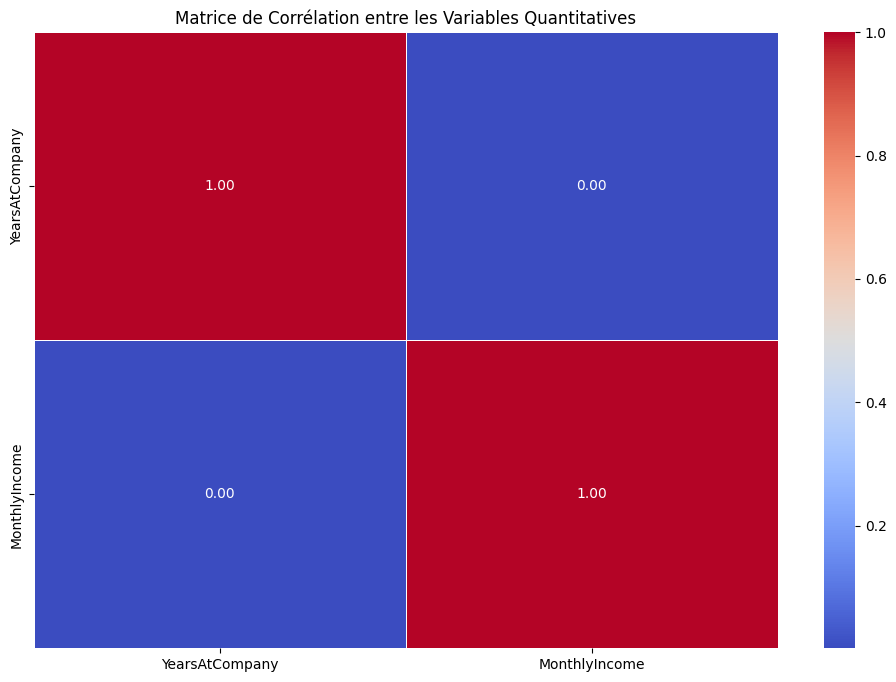

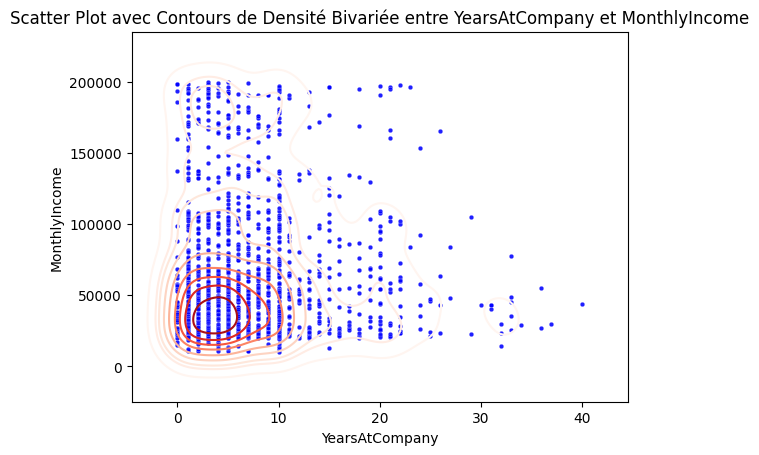

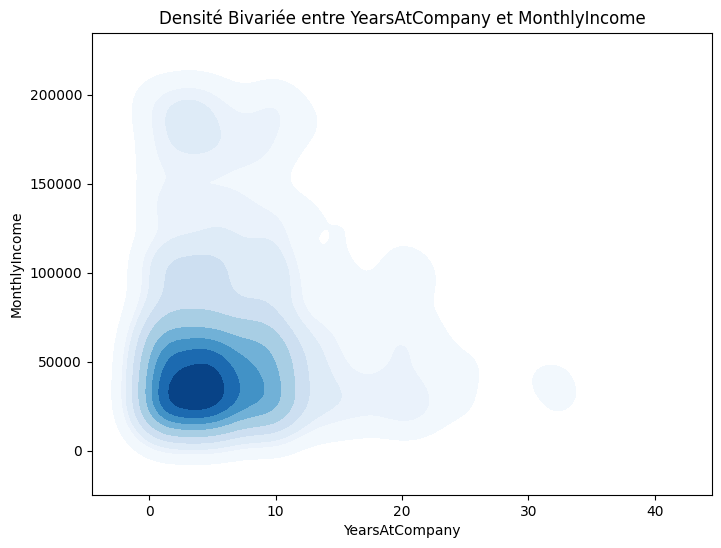

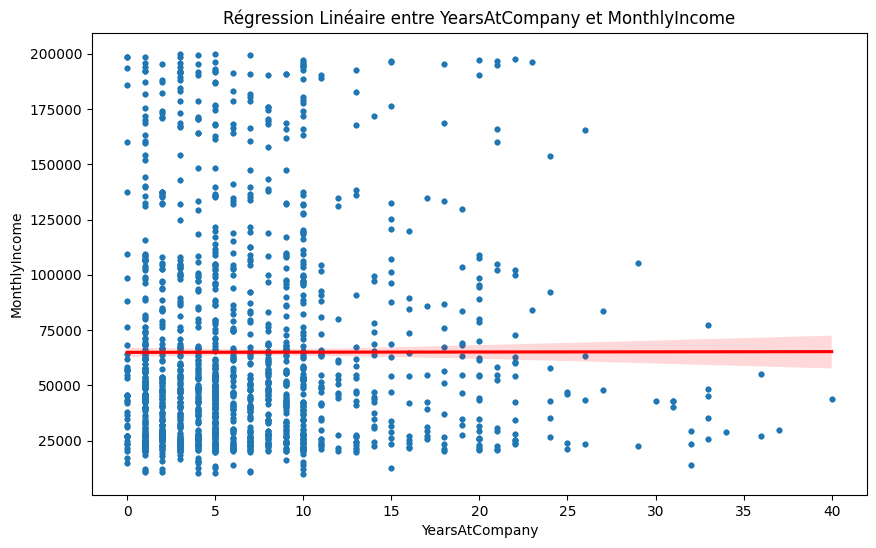

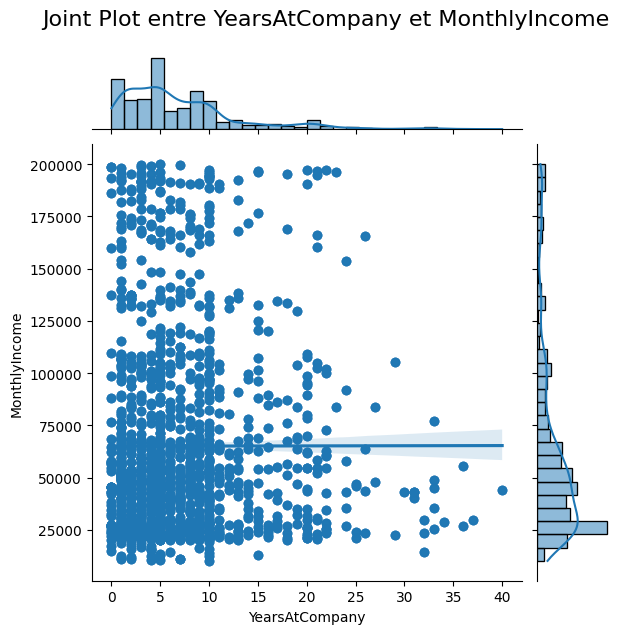

In [ ]:
analyse_num_num(company_df,'YearsAtCompany','MonthlyIncome')